In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from helper import *

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import *
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
with open('mappings.json', 'r') as f:
    mappings = json.load(f)

# mappings = {re.sub('[^A-Za-z0-9]+$', '', k): v for k, v in mappings.items()}

with open('wave1_vars.json', 'r') as f:
    dict1 = json.load(f)

with open('wave2_vars.json', 'r') as f:
    dict2 = json.load(f)

with open('wave1_netvars.json', 'r') as f:
    dict3 = json.load(f)

In [3]:
df_C1W1nonet = pd.read_csv('C1W1_nonnetwork.csv')
df_C1W2nonet = pd.read_csv('C1W2_nonnetwork.csv')
df_C1W1net = pd.read_csv('C1W1_network.csv')

Remove irrelevant/insignificant variables

- IDs of participants/interviewers
- Text variables
- Multiple choices (DA7a-d, DA8a-d)

In [4]:
df_C1W1nonet = df_C1W1nonet.drop(columns=['PID','PID2','ID13','ID14','ND13','ND15',
                            'DA7a','DA7a_11_TEXT','DA7b','DA7b_11_TEXT','DA7c','DA7c_13_TEXT','DA7d','DA7d_11_TEXT',
                            'DA8a','DA8a_13_TEXT','DA8b','DA8b_11_TEXT','DA8c','DA8c_11_TEXT','DA8d','DA8d_11_TEXT',
                            'DM12_6_TEXT'])
df_C1W2nonet = df_C1W2nonet.drop(columns=['PID','PID2','Interviewer_ID','Q50','Q51','Q81','Q84',
                                        'Q103_R11_Other','Q105_R11_Other','Q207_R5','Q208_R4'])
df_C1W1net = df_C1W1net.drop(columns=['NDX5J_6_TEXT','NDX6J_8_TEXT','NDX6K_14_TEXT','NDX5L_10_TEXT','NDX6L_13_TEXT',
                                    'NDX5M_10_TEXT','NDX6M_13_TEXT','NDX5N_10_TEXT','NDX6N_13_TEXT','NDX5O_11_TEXT',
                                    'NDX6O_14_TEXT','NDX5P_10_TEXT','NDX6P_13_TEXT','NDX5Q_10_TEXT','NDX6Q_13_TEXT',
                                    'NDX5R_10_TEXT','NDX6R_13_TEXT'])

All substances (4 main groups):

- Tobacco
- Alcohol
- Injection drug
    - heroin
    - prescription opioids
    - methamphetamine
    - cocaine
    - heroin and cocaine speedball
    - heroin and methamphetamine speedball
    - crack cocaine
    - buprenorphine
- Non-injection drug
    - marijuana
    - cocaine
    - Ecstasy/MDMA
    - PCP/angel dust
    - amphetamines
    - methamphetamine
    - barbiturates
    - benzodiazepines
    - opiates/opioids
    - heroin

### Missing Data Imputation

Note that below blocks only impute MNAR data, MAR data is manually imputed beforehand.

If variable type is (pure) numerical, impute using the mean of corresponding column.

In [5]:
vars_num = ['SC1','DM1']  # all numerical variables in W1

for v in vars_num:
    col = df_C1W1nonet[v]
    df_C1W1nonet[v] = col.fillna(col.mean())

If variable type is mixed (e.g., age first did sth, or never, or don't know), convert into pure categorical:

[0: 0-14 years old; 1: 15-24; 2: 25-64; 3: >=65; 4: never; 5: don't know]

In [6]:
vars_mixed = ['TB2','TB6','TB10','AL1','AL2','AL3','ID2','ND2']

for v in vars_mixed:
    col = df_C1W1nonet[v]
    for idx, i in enumerate(col):
        if 0 <= i <= 14:    df_C1W1nonet.at[idx, v] = 0  # children
        elif 15 <= i <= 24: df_C1W1nonet.at[idx, v] = 1  # youth
        elif 25 <= i <= 64: df_C1W1nonet.at[idx, v] = 2  # adult
        elif i >= 65:       df_C1W1nonet.at[idx, v] = 3  # senior
        elif i == -1:       df_C1W1nonet.at[idx, v] = 4  # never
        elif i == -2:       df_C1W1nonet.at[idx, v] = 5  # don't know

If variable type is categorical/binary, impute using the most frequent value of corresponding column.

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(df_C1W1nonet, y, test_size = 0.30)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(df_C1W1nonet)
X_imp = imp.transform(df_C1W1nonet)

In [8]:
print(X_imp.shape)
print(f'Any nan left? {np.isnan(X_imp).any()}')

(35, 176)
Any nan left? False


### Grouping Features

In [9]:
f_dict = {}
fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
for g in fgroups:
    features = [c for c in df_C1W1nonet if c.startswith(g)]
    f_indices = [df_C1W1nonet.columns.get_loc(c) for c in df_C1W1nonet if c.startswith(g)]  # column indices of the group's features
    f_dict[g] = f_indices
    print(f'{g} ({len(features)}): {features}')

SC (8): ['SC1', 'SC3', 'SC4', 'SC5', 'SC6', 'SC8', 'SC9', 'SC13']
DM (10): ['DM1', 'DM8', 'DM9', 'DM10', 'DM12', 'DM13', 'DM14', 'DM15', 'DM17', 'DM23']
TB (12): ['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'TB10', 'TB11', 'TB12']
AL (6): ['AL1', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6']
ID (18): ['ID1', 'ID2', 'ID3', 'ID4', 'ID5', 'ID6', 'ID7', 'ID8', 'ID9', 'ID10', 'ID11', 'ID12', 'ID15', 'ID16', 'ID17', 'ID18', 'ID19', 'ID20']
ND (12): ['ND1', 'ND2', 'ND3', 'ND4', 'ND5', 'ND6', 'ND7', 'ND8', 'ND9', 'ND10', 'ND11', 'ND12']
DA (56): ['DA1_1', 'DA1_2', 'DA1_3', 'DA1_4', 'DA1_5', 'DA1_6', 'DA1_7', 'DA2_1', 'DA2_2', 'DA2_3', 'DA2_4', 'DA2_5', 'DA2_6', 'DA2_7', 'DA5_R1', 'DA5_R2', 'DA5_R3', 'DA5_R4', 'DA5_R5', 'DA6_R1', 'DA6_R2', 'DA6_R3', 'DA6_R4', 'DA6_R5', 'DA7_R1', 'DA7_R2', 'DA7_R3', 'DA7_R4', 'DA7_R5', "DA7'_R1", "DA7'_R2", "DA7'_R3", "DA7'_R4", "DA7'_R5", "DA7'_R6", "DA7'_R7", "DA7'_R8", "DA7'_R9", "DA7'_R10", "DA7'_R11", 'DA8_R1', 'DA8_R2', 'DA8_R3', 'DA8_R4', 'DA8_R5'

Example: access feature group 'AL' directly from X_imp (2D array)

In [10]:
print(X_imp[:,f_dict['AL']].shape)
X_imp[:,f_dict['AL']]

(35, 6)


array([[1., 1., 1., 1., 4., 3.],
       [0., 1., 1., 1., 3., 1.],
       [1., 1., 2., 1., 7., 3.],
       [0., 1., 1., 1., 4., 2.],
       [1., 1., 1., 1., 5., 5.],
       [1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 7., 5.],
       [5., 5., 5., 1., 7., 0.],
       [4., 4., 4., 0., 0., 0.],
       [4., 4., 4., 0., 0., 0.],
       [0., 1., 2., 1., 7., 6.],
       [0., 0., 0., 1., 4., 5.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 2., 1., 0., 0.],
       [1., 1., 1., 1., 4., 0.],
       [1., 1., 1., 1., 4., 2.],
       [0., 1., 0., 1., 6., 5.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 6., 6.],
       [1., 1., 1., 1., 7., 0.],
       [1., 1., 5., 1., 1., 0.],
       [1., 5., 2., 1., 1., 0.],
       [1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 5., 1.],
       [1., 1., 1., 1., 7., 5.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 7., 4.],
       [1., 1., 1., 1., 6., 6.],
       [1.

Example: access list of feature groups ['AL', 'ID'] directly from X_imp (2D array)

In [11]:
fsubsets = ['AL', 'ID']
def get_f_indices(fsubsets):  # concatenate multiple feature groups (lists) into one big list of features
    return [f for fgroup in [f_dict[s] for s in fsubsets] for f in fgroup]

X_imp[:,get_f_indices(fsubsets)]

array([[ 1.,  1.,  1.,  1.,  4.,  3.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 0.,  1.,  1.,  1.,  3.,  1.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  2.,  1.,  7.,  3.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 0.,  1.,  1.,  1.,  4.,  2.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  5.,  5.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 0.,  1.,  1.,  1.,  7.,  5.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1., -1.],
       [ 5.,  5.,  5.,  1.,  7.,  0.,  0.

In [99]:
fsubs_1, fsubs_2, fsubs_3, fsubs_4 = ['SC'], ['DM'], ['TB','AL','ID','ND','DA','OD'], ['TX','AC','CJ']
fsubs_5 = fsubs_1 + fsubs_2
fsubs_6 = fsubs_1 + fsubs_2 + fsubs_3
fsubs_7 = fsubs_1 + fsubs_2 + fsubs_4
fsubs_8 = fsubs_1 + fsubs_2 + fsubs_3 + fsubs_4
fsubs_all = {'g1': fsubs_1, 'g2': fsubs_2, 'g3': fsubs_3, 'g4': fsubs_4, 'g5': fsubs_5, 'g6': fsubs_6, 'g7': fsubs_7, 'g8': fsubs_8}
# X_imp[:,get_f_indices(fsubsets)]

### Labeling

Binary labels indicating whether participants use more or less of each substance in wave 2 compared to wave 1

In [12]:
y_tobacco = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1])
y_alcohol = np.array([1,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,1,1,0,0,0,1,1,0,0,0,0,1])
y_inj =     np.array([0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0])
y_noninj =  np.array([0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0])
y_all = {'tobacco': y_tobacco, 'alcohol': y_alcohol, 'injection': y_inj, 'non-injection': y_noninj}

def calc_bm(y):
    return 1 - np.sum(y)/len(y)

# if we classify everyone into the majority negative class (0), what is the accuracy?
print(f'benchmark: tobacco = {calc_bm(y_tobacco)}, alcohol = {calc_bm(y_alcohol)}, inj = {calc_bm(y_inj)}, noninj = {calc_bm(y_noninj)}')

benchmark: tobacco = 0.7142857142857143, alcohol = 0.5142857142857142, inj = 0.7142857142857143, noninj = 0.6


### Training

#### Logistic Regression

Consider all feature groups with grid search

Note that when `scoring='accuracy'` and `cv=LeaveOneOut()`, the resulting `best_score_` from the grid is equal to the average acc from LOOCV

In [17]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid = dict(penalty=penalty, C=C)
grid = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=17, class_weight='balanced'),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=LeaveOneOut())

In [18]:
X = standard_scale(X_imp)
# X = X_imp
final_accs = []
for drug, y in y_all.items():  # for each substance
    param_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    grid = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=17, class_weight='balanced', solver='liblinear'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=LeaveOneOut())

    grid.fit(X, y)
    final_accs.append(grid.best_score_)

In [19]:
final_accs

[0.8, 0.6571428571428571, 0.7142857142857143, 0.6]

Try exhaustively on different subsets of feature groups, with grid search

In [14]:
@ignore_warnings(category=ConvergenceWarning)
def log_regression(fsubset):
    X = standard_scale(X_imp[:,get_f_indices(fsubset)])  # standardize data since regularization is used (also improve runtime)
    final_accs = []
    for drug, y in y_all.items():  # for each substance
        param_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
        grid = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=17, class_weight='balanced', solver='liblinear'),
                            param_grid=param_grid,
                            scoring='accuracy',
                            cv=LeaveOneOut())

        grid.fit(X, y)
        final_accs.append(grid.best_score_)

    return (fsubset, final_accs)

In [15]:
# what are your inputs, and what operation do you want to
# perform on each input. For example...
inputs = list(powerset(fgroups))[1:]

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(log_regression)(i) for i in inputs)

#### Decision Trees

Note: Even when setting `max_features = n_features`, there is still randomness in the estimator, i.e., each run of model training is nondeterministic. This is due to the fact that if the splits' impurity measures are identical (e.g., same lowest gini scores), one split has to be selected at random. Thus, generate 100 seeds and average the accuracies across 100 runs afterwards.

See https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [25]:
n_seeds = 100

for drug, y in y_all.items():  # for each substance
    mean_acc_list = []
    for i in range(n_seeds):
        model = DecisionTreeClassifier(class_weight='balanced',
                                        max_features=len(df_C1W1nonet.columns),  # max_features = n features i.e., all
                                        splitter='best',
                                        random_state=i)
        acc = loocv(X_imp, y, model)  # mean acc of 1 run (i.e., 1 seed) after performing LOOCV
        # print(acc)
        mean_acc_list.append(acc)


    print(f'final accuracy for {drug}: {np.mean(mean_acc_list)} +- {np.std(mean_acc_list)}')

final accuracy for tobacco: 0.6488571428571427 +- 0.029219786418920785
final accuracy for alcohol: 0.5654285714285714 +- 0.04768861584941057
final accuracy for injection: 0.5825714285714284 +- 0.03634191373438597
final accuracy for non-injection: 0.34571428571428575 +- 0.05903993805649093


A closer look into one instance

0.6285714285714286


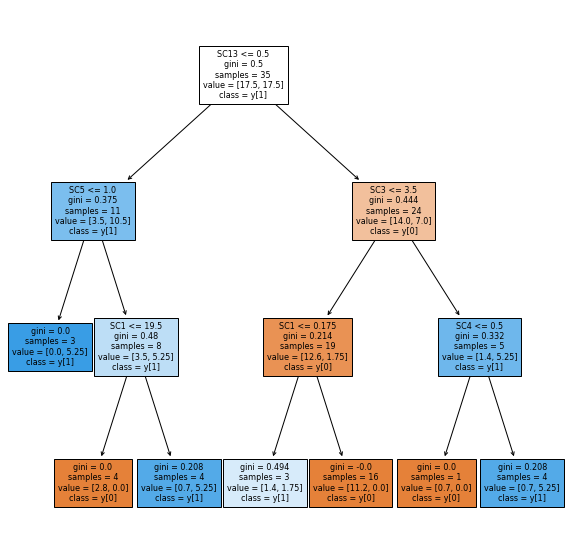

In [13]:
X = X_imp[:,get_f_indices(['SC'])]
y = y_tobacco
clf = DecisionTreeClassifier(class_weight='balanced',
                            max_depth=3,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            min_impurity_decrease=0,
                            random_state=17)
print(np.mean(cross_val_score(clf, X, y, cv=LeaveOneOut())))

plt.figure(figsize=(10,10))
plot_tree(clf.fit(X, y),filled=True,fontsize=8,feature_names=list(df_C1W1nonet.columns),class_names=True)
plt.show()

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=4,
                       min_samples_split=5, random_state=17)
0.6285714285714286


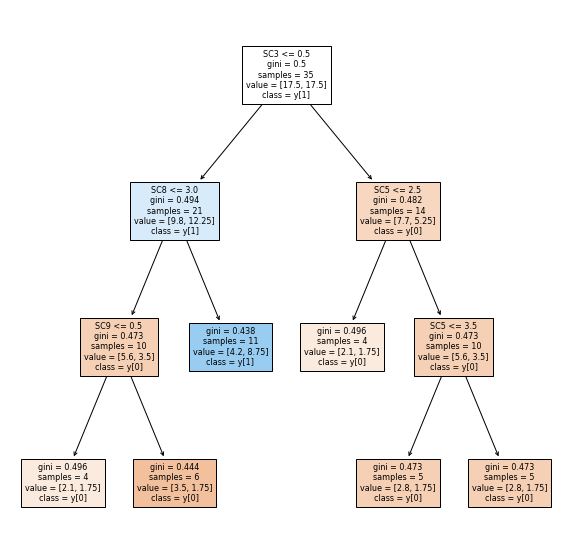

In [60]:
X = X_imp[:,get_f_indices(['TB'])]  # standardize data since regularization is used (also improve runtime)
y = y_tobacco

param_grid = dict(max_depth=range(2,6), min_samples_split=[5, 10, 15], min_samples_leaf=range(1,6))
grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=17, class_weight='balanced'),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=LeaveOneOut())
grid.fit(X, y)

print(grid.best_estimator_)
print(grid.best_score_)

plt.figure(figsize=(10,10))
plot_tree(grid.best_estimator_,filled=True,fontsize=8,feature_names=list(df_C1W1nonet.columns),class_names=True)
plt.show()

Compare computational time between regular for loop (1 core) vs multiprocessing (20 cores/cpus)

We see the improvement factor is 5.

In [93]:
def decision_trees(fsubset, n_seeds):  # fsubset: subset of feature groups
    X = X_imp[:,get_f_indices(fsubset)]
    final_accs = []
    for drug, y in y_all.items():  # for each substance
        mean_acc_list = []
        for i in range(n_seeds):
            model = DecisionTreeClassifier(class_weight='balanced',
                                            max_features=X.shape[1],  # max_features = n features i.e., all
                                            splitter='best',
                                            random_state=i)
            acc = loocv(X, y, model)  # mean acc of 1 run (i.e., 1 seed) after performing LOOCV
            # print(acc)
            mean_acc_list.append(acc)

        final_accs.append( (np.mean(mean_acc_list), np.std(mean_acc_list)) )

    return (fsubset, final_accs)

In [97]:
# what are your inputs, and what operation do you want to
# perform on each input. For example...
inputs = list(powerset(fgroups))[1:11]

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(decision_trees)(i, n_seeds=100) for i in inputs)

In [100]:
results = []
for comb in list(powerset(fgroups))[1:11]:
    results.append(decision_trees(comb, n_seeds=100))

Run on all subsets of feature groups (no pruning, many seeds)

In [102]:
inputs = list(powerset(fgroups))[1:]

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(decision_trees)(i, n_seeds=100) for i in inputs)
# format: results[i] = ( (f1,f2,f3), [(x,x), (x,x), (x,x), (x,x)] )

In [119]:
TB_dict, AL_dict, ID_dict, ND_dict = {}, {}, {}, {}
for r in results:
    TB_dict[tuple(r[0])] = r[1][0][0]
    AL_dict[tuple(r[0])] = r[1][1][0]
    ID_dict[tuple(r[0])] = r[1][2][0]
    ND_dict[tuple(r[0])] = r[1][3][0]

print(f'{max(TB_dict, key=TB_dict.get)}, {max(AL_dict, key=AL_dict.get)}, {max(ID_dict, key=ID_dict.get)}, {max(ND_dict, key=ND_dict.get)}')

('AL', 'ND', 'TX'), ('AL', 'ID', 'ND', 'AC'), ('OD', 'TX', 'CJ'), ('ID', 'OD', 'TX', 'CJ')


In [121]:
print(TB_dict[('AL', 'ND', 'TX')])
print(AL_dict[('AL', 'ID', 'ND', 'AC')])
print(ID_dict[('OD', 'TX', 'CJ')])
print(ND_dict[('ID', 'OD', 'TX', 'CJ')])

0.8688571428571429
0.7831428571428571
0.7831428571428571
0.7771428571428569


Run on all subsets of feature groups (with pruning, one seed)

In [61]:
def pruned_decision_trees(fsubset):
    X = X_imp[:,get_f_indices(fsubset)]
    final_accs = []
    for drug, y in y_all.items():  # for each substance
        param_grid = dict(max_depth=range(2,6), min_samples_split=[5, 10, 15], min_samples_leaf=range(1,6))
        grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=17, class_weight='balanced'),
                            param_grid=param_grid,
                            scoring='accuracy',
                            cv=LeaveOneOut())

        grid.fit(X, y)
        final_accs.append(grid.best_score_)

    return (fsubset, final_accs)

In [63]:
inputs = list(powerset(fgroups))[1:]

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(pruned_decision_trees)(i) for i in inputs)

#### SVM

In [77]:
def svm(fsubset):
    X = standard_scale(X_imp[:,get_f_indices(fsubset)])  # standardize data
    final_accs = []
    for drug, y in y_all.items():  # for each substance
        param_grid = dict(kernel=['linear','poly','rbf','sigmoid'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
        grid = GridSearchCV(estimator=SVC(random_state=17, class_weight='balanced'),
                            param_grid=param_grid,
                            scoring='accuracy',
                            cv=LeaveOneOut())

        grid.fit(X, y)
        final_accs.append((grid.best_score_, grid.best_params_))

    return (fsubset, final_accs)

In [79]:
svm(list(powerset(fgroups))[-1])

(('SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ'),
 [(0.7142857142857143, {'C': 0.0001, 'kernel': 'poly'}),
  (0.7714285714285715, {'C': 0.0001, 'kernel': 'rbf'}),
  (0.7142857142857143, {'C': 0.0001, 'kernel': 'linear'}),
  (1.0, {'C': 0.1, 'kernel': 'rbf'})])

#### Random Forest

In [24]:
n_seeds = 10

for drug, y in y_all.items():
    mean_acc_list = []
    for i in range(n_seeds):
        model = RandomForestClassifier(n_estimators=100,
                                        class_weight='balanced',
                                        max_features='sqrt',  # max_features = sqrt(n_features)
                                        bootstrap=True,
                                        random_state=i)
        acc = loocv(X_imp, y, model)  # mean acc of 1 run (i.e., 1 seed) after performing LOOCV
        # print(acc)
        mean_acc_list.append(acc)


    print(f'final accuracy for {drug}: {np.mean(mean_acc_list)} +- {np.std(mean_acc_list)}')

final accuracy for tobacco: 0.7200000000000001 +- 0.011428571428571432
final accuracy for alcohol: 0.5171428571428571 +- 0.0548839220351387
final accuracy for injection: 0.6885714285714286 +- 0.020000000000000007
final accuracy for non-injection: 0.44000000000000006 +- 0.05299210568854687


In [ ]:
model = 'forest'

y = np.array([list(a) for a in zip(y_tobacco, y_alcohol, y_inj, y_noninj)])
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.3, random_state=42)

if model == 'logreg':
    clf = MultiOutputClassifier(LogisticRegression(solver='liblinear', penalty='l1')).fit(X_train, y_train)
elif model == 'forest':
    clf = MultiOutputClassifier(RandomForestClassifier()).fit(X_train, y_train)

predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f'predictions: {predictions}')
print(f'test labels: {y_test}')
print(score)

# RocCurveDisplay.from_predictions(y_test,predictions)

predictions: [[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]
test labels: [[0 0 1 1]
 [0 1 0 1]
 [0 1 0 1]
 [0 0 0 0]
 [0 0 1 1]
 [0 1 0 0]
 [1 0 1 1]
 [0 0 0 1]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]
0.18181818181818182


### PCA

In [ ]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_imp)
pca.explained_variance_ratio_

array([5.89880388e-01, 1.77891368e-01, 3.38629616e-02, 2.89192615e-02,
       2.29850290e-02, 1.59752731e-02, 1.57407439e-02, 1.14975997e-02,
       1.03707175e-02, 9.23910129e-03, 8.90749321e-03, 7.87784523e-03,
       7.11929275e-03, 7.01044225e-03, 5.93853573e-03, 5.65753912e-03,
       4.64920903e-03, 4.29160508e-03, 4.14284049e-03, 3.86177163e-03,
       3.26924060e-03, 3.10649945e-03, 2.88756061e-03, 2.40806662e-03,
       1.74972887e-03, 1.58729657e-03, 1.40023106e-03, 1.37961446e-03,
       1.34423304e-03, 1.33633933e-03, 1.10915692e-03, 1.10061010e-03,
       8.87306430e-04, 6.15097712e-04, 1.16333394e-31])

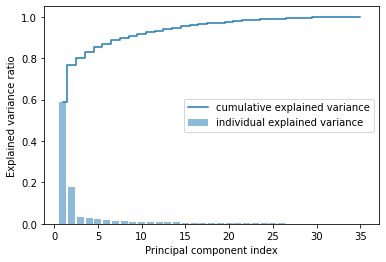

In [ ]:
plt.bar(range(1,36), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,36), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='right')
plt.show()

### Learning Curve

See more here: https://arxiv.org/pdf/2103.10948

In [82]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    # # Plot n_samples vs fit_times
    # axes[1].grid()
    # axes[1].plot(train_sizes, fit_times_mean, "o-")
    # axes[1].fill_between(
    #     train_sizes,
    #     fit_times_mean - fit_times_std,
    #     fit_times_mean + fit_times_std,
    #     alpha=0.1,
    # )
    # axes[1].set_xlabel("Training examples")
    # axes[1].set_ylabel("fit_times")
    # axes[1].set_title("Scalability of the model")

    # # Plot fit_time vs score
    # fit_time_argsort = fit_times_mean.argsort()
    # fit_time_sorted = fit_times_mean[fit_time_argsort]
    # test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    # test_scores_std_sorted = test_scores_std[fit_time_argsort]
    # axes[2].grid()
    # axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    # axes[2].fill_between(
    #     fit_time_sorted,
    #     test_scores_mean_sorted - test_scores_std_sorted,
    #     test_scores_mean_sorted + test_scores_std_sorted,
    #     alpha=0.1,
    # )
    # axes[2].set_xlabel("fit_times")
    # axes[2].set_ylabel("Score")
    # axes[2].set_title("Performance of the model")

    return plt

In [35]:
def plot_LC(X, y, y_name, n_estimators=3):

    fig, axes = plt.subplots(3, n_estimators, figsize=(15, 15))

    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    # cv = LeaveOneOut()

    title = "Learning Curves (logistic regression)"
    # Cross validation with 10 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    estimator = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear', C=10)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[:,0], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    title = "Learning Curves (decision tree)"
    estimator = DecisionTreeClassifier(class_weight='balanced', splitter='best', max_depth=3)
    plot_learning_curve(
        estimator, title, X, y, axes=axes[:,1], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    title = "Learning Curves (SVM)"
    estimator = SVC(kernel='rbf', C=10)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[:,2], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    fig.suptitle(y_name + ' use', y=0.92)
    plt.show()

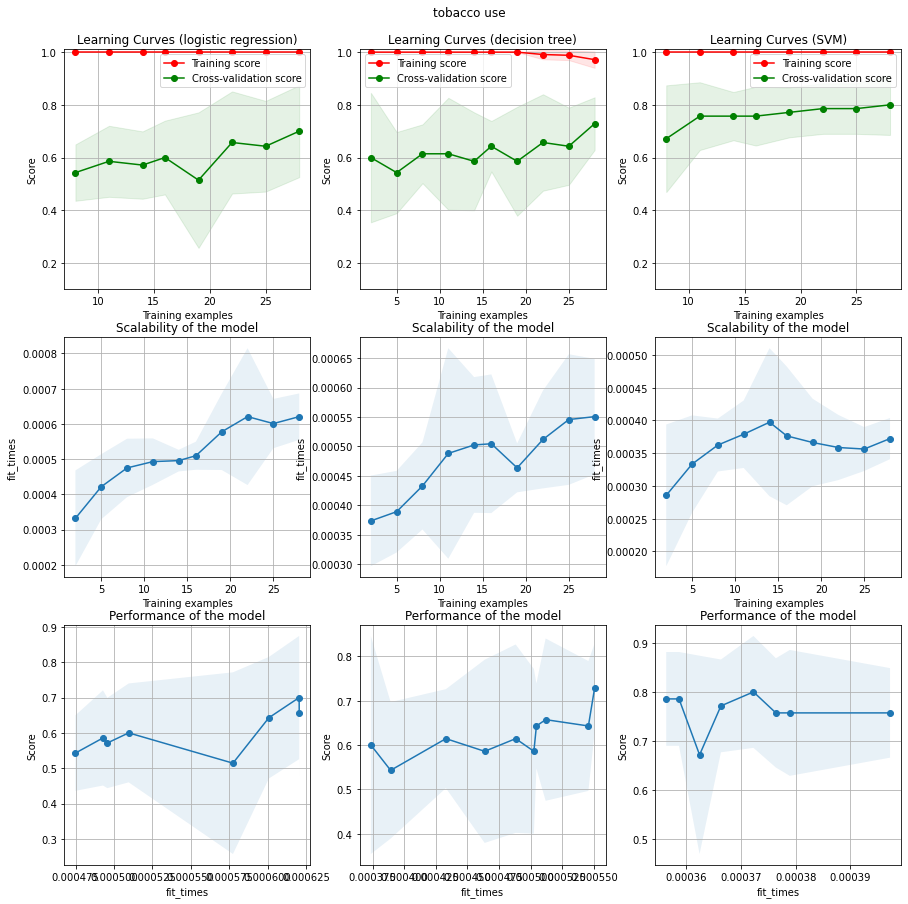

In [54]:
plot_LC(X_imp, y_tobacco, 'tobacco')
# plot_LC(X_imp, y_alcohol, 'alcohol')
# plot_LC(X_imp, y_inj, 'injection drug')
# plot_LC(X_imp, y_noninj, 'non-injection drug')

Feed the best params found from GridSearchCV into the model's learning curve

In [112]:
@ignore_warnings(category=ConvergenceWarning)
def log_regression_tuned(X, y):
    param_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    clf = GridSearchCV(estimator=LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=StratifiedKFold())
    clf.fit(standard_scale(X), y)

    return clf.best_estimator_

def pruned_decision_trees_tuned(X, y):
    param_grid = dict(max_depth=range(2,6), min_samples_split=[5, 10, 15], min_samples_leaf=range(1,6))
    clf = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=StratifiedKFold())
    clf.fit(X, y)

    return clf.best_estimator_

def svm_tuned(X, y):
    param_grid = dict(kernel=['linear','poly','rbf','sigmoid'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    clf = GridSearchCV(estimator=SVC(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=StratifiedKFold())
    clf.fit(standard_scale(X), y)

    return clf.best_estimator_


def plot_LC_tuned(X, y, y_name, gname, n_estimators=3):

    fig, axes = plt.subplots(1, n_estimators, figsize=(15, 5))

    # Cross validation with 50 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

    title = "Learning Curves (logistic regression)"
    estimator = log_regression_tuned(X, y)
    # print(f'Log regression: {estimator}')
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[0], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    title = "Learning Curves (decision tree)"
    estimator = pruned_decision_trees_tuned(X, y)
    # print(f'Decision tree: {estimator}')
    plot_learning_curve(
        estimator, title, X, y, axes=axes[1], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    title = "Learning Curves (SVM)"
    estimator = svm_tuned(X, y)
    # print(f'SVM: {estimator}')
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[2], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy"
    )

    fig.suptitle(y_name + ' use: group ' + gname)
    plt.savefig(f'plots/{gname}_{y_name}_learningCurve.png', facecolor='white')

/tmp/ipykernel_306/3662334117.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, n_estimators, figsize=(15, 5))


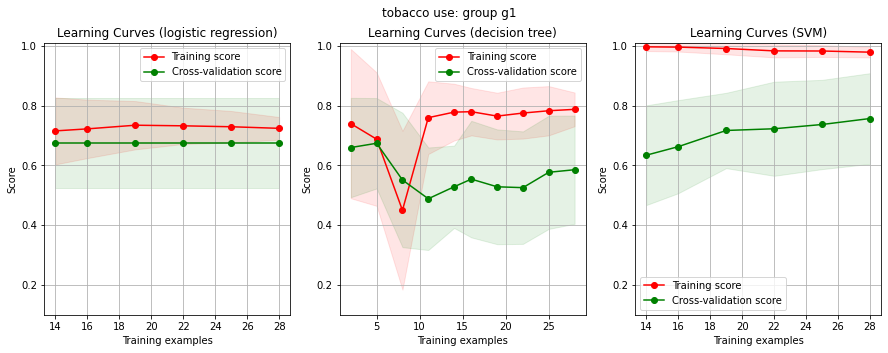

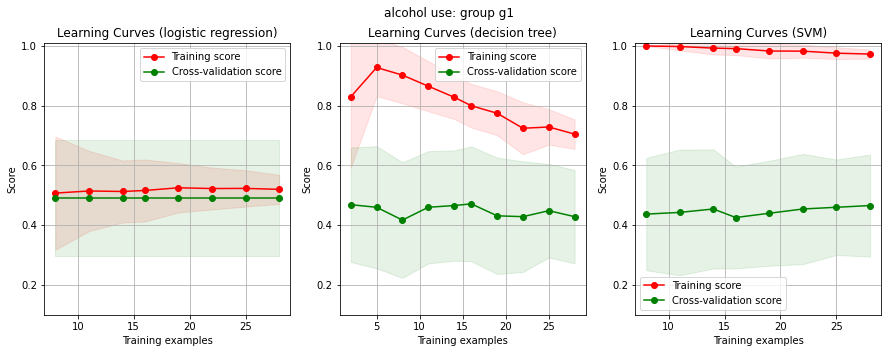

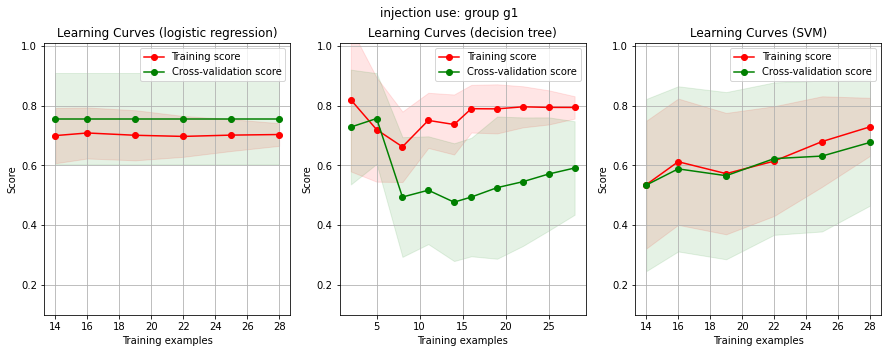

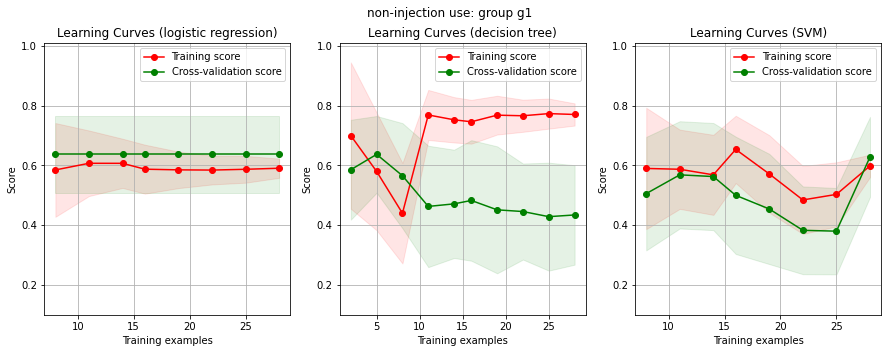

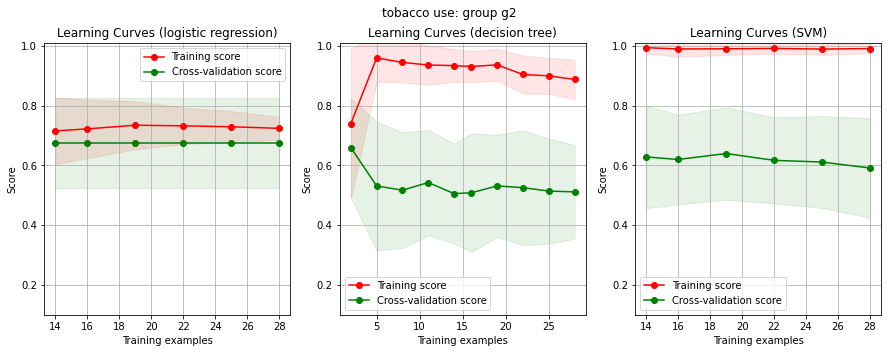

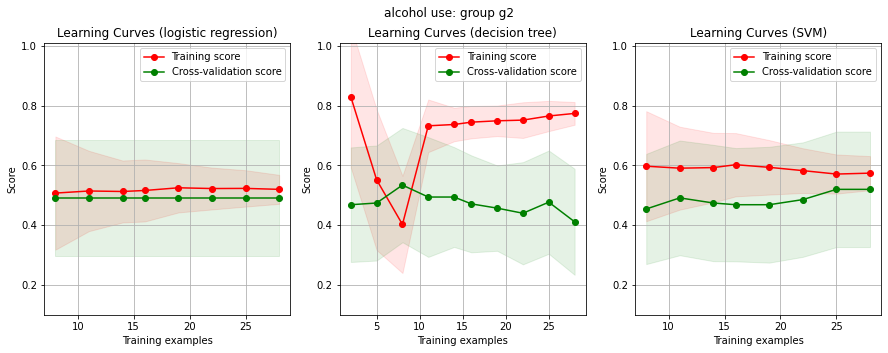

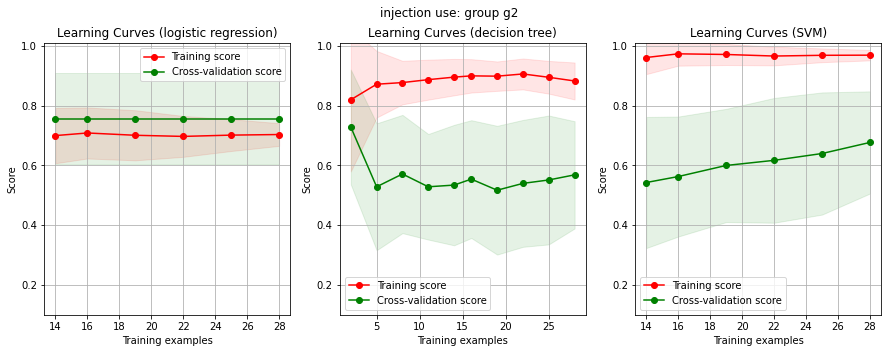

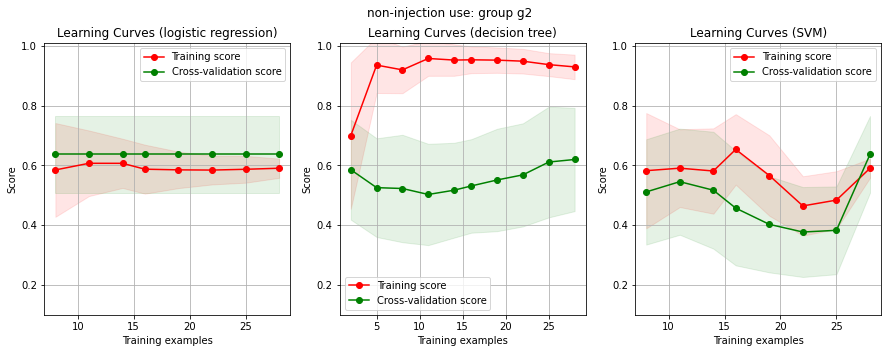

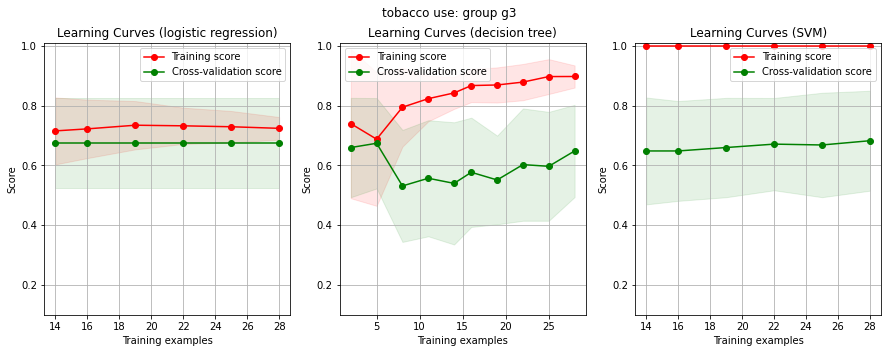

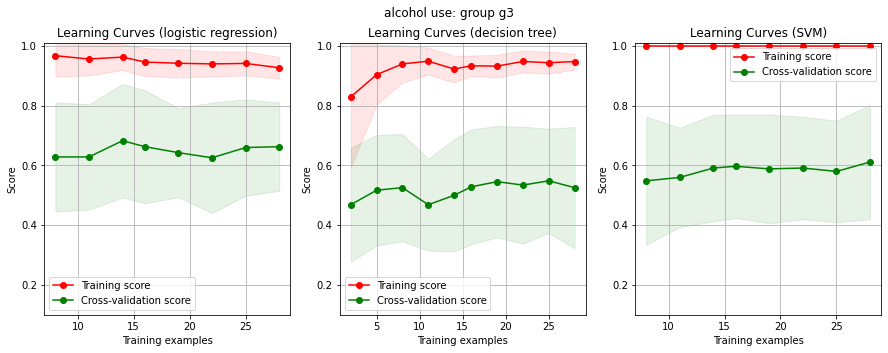

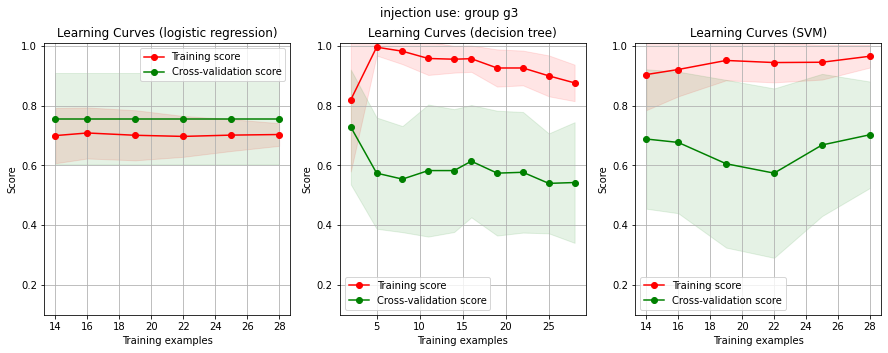

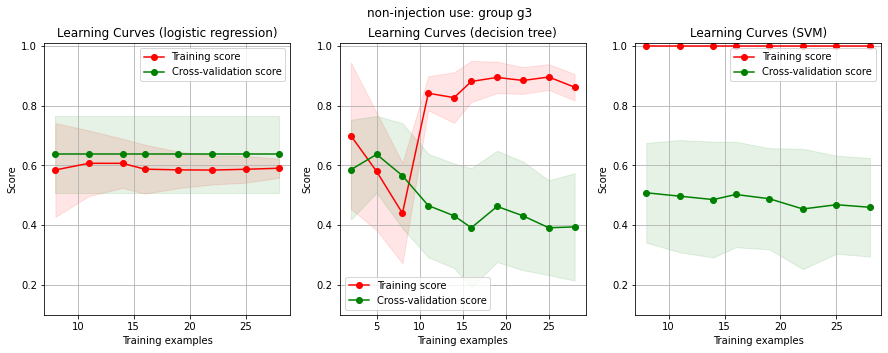

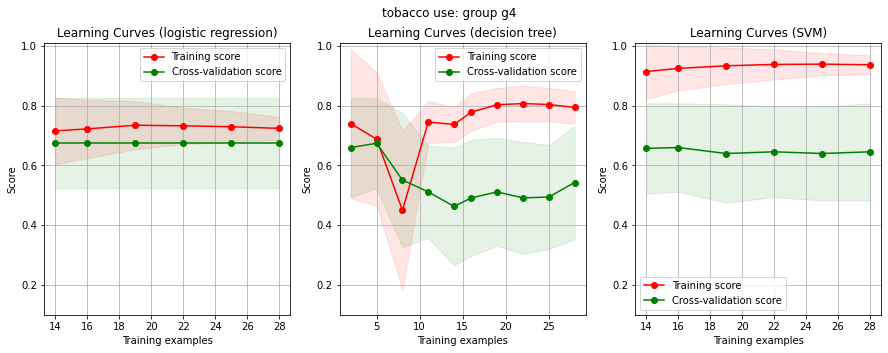

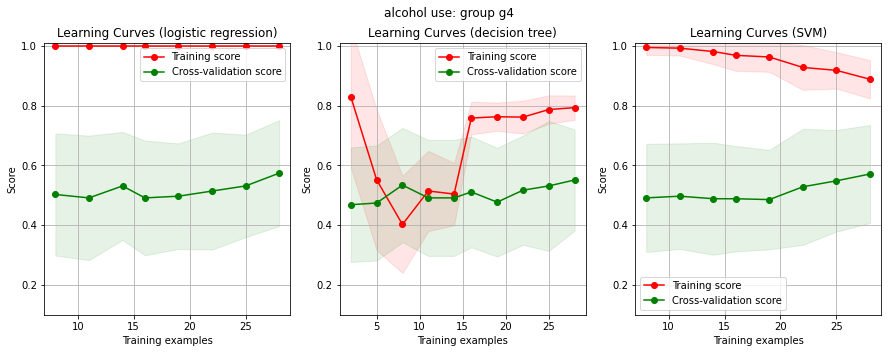

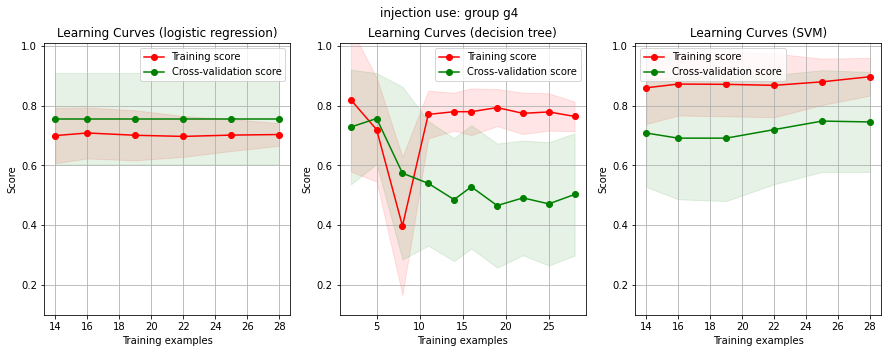

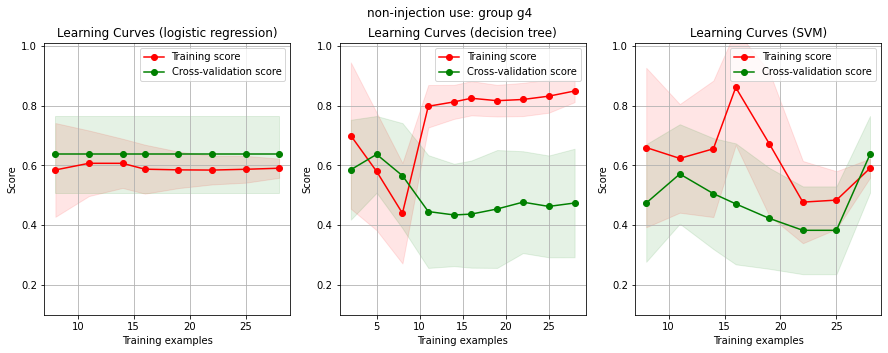

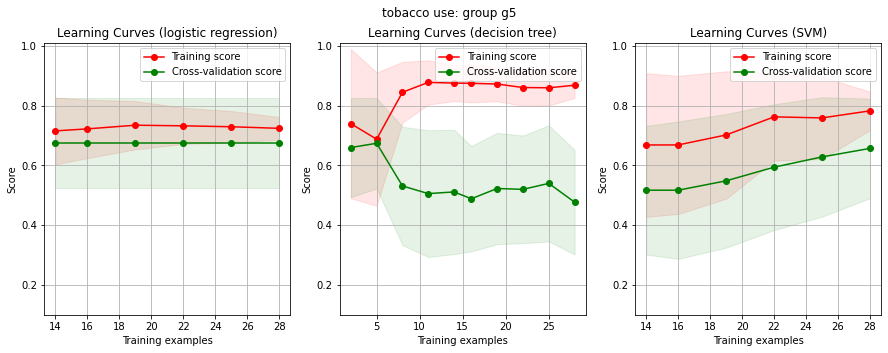

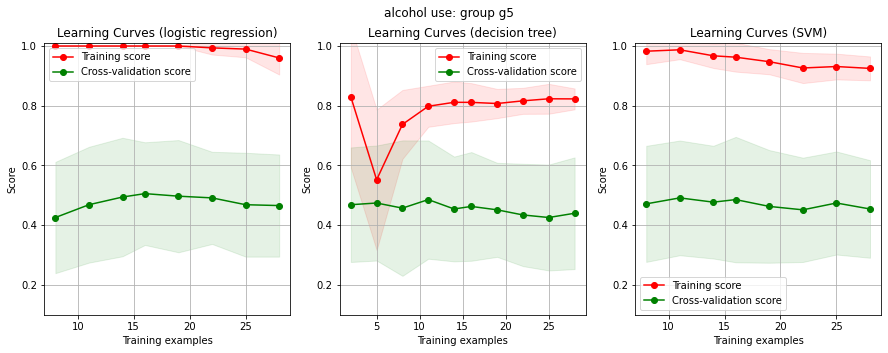

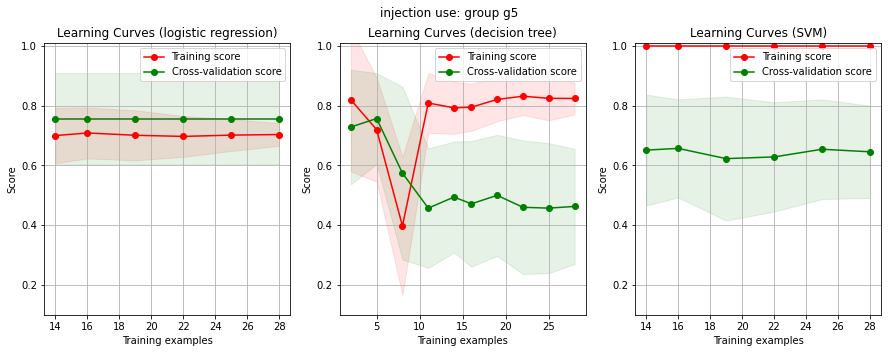

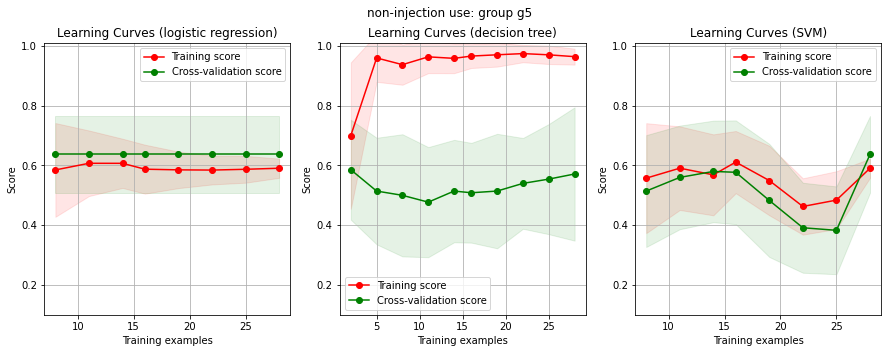

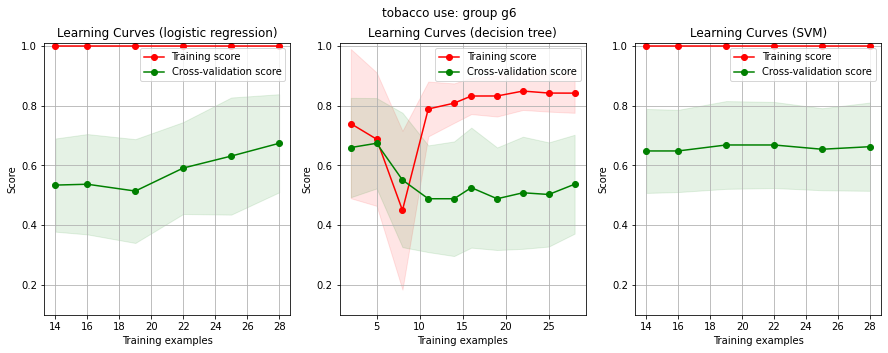

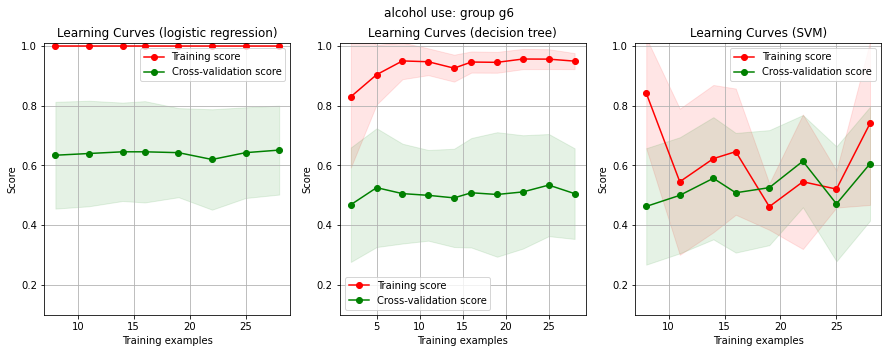

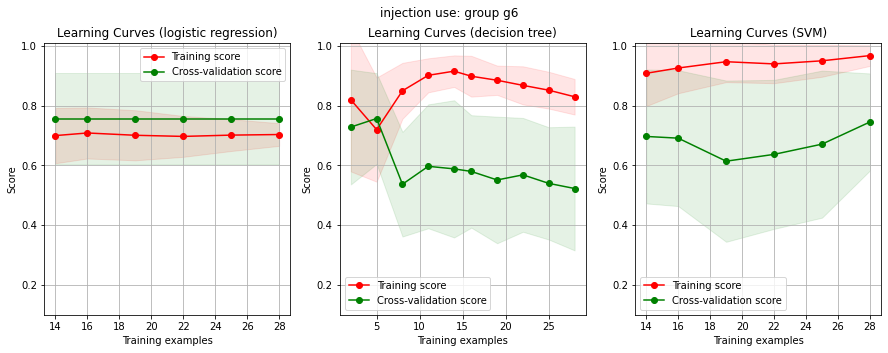

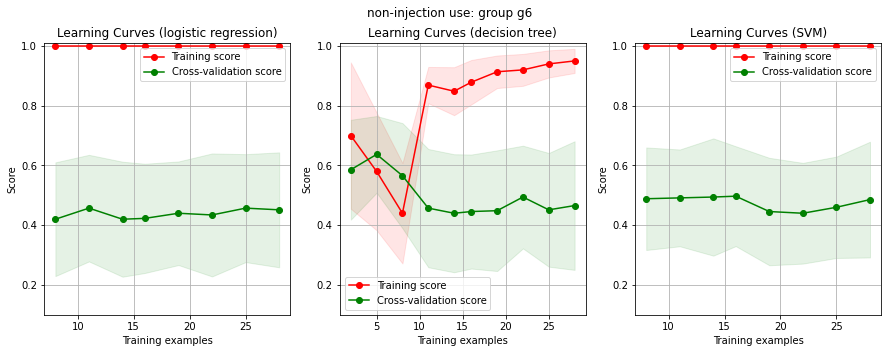

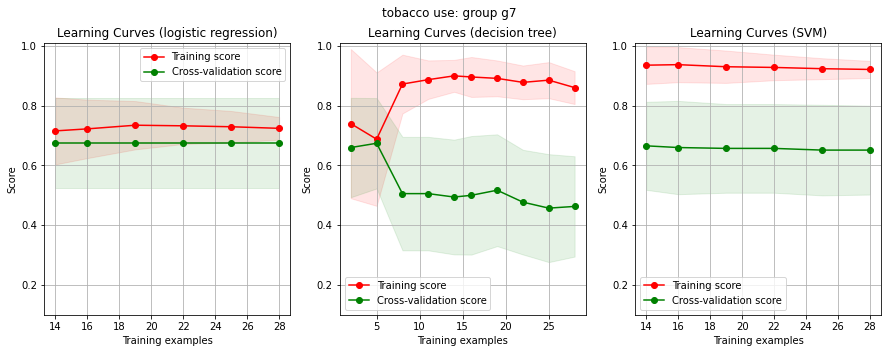

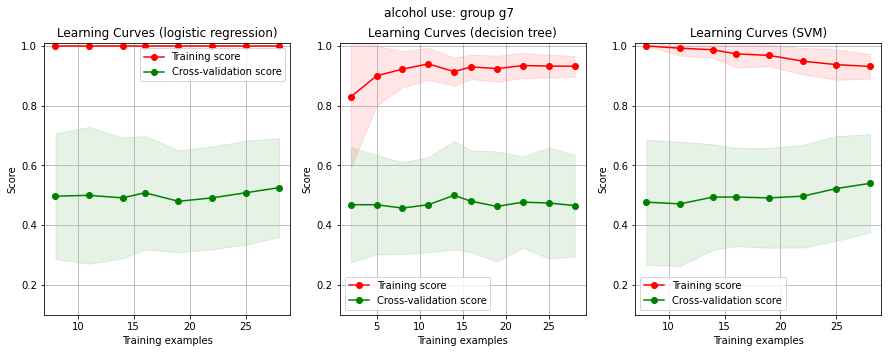

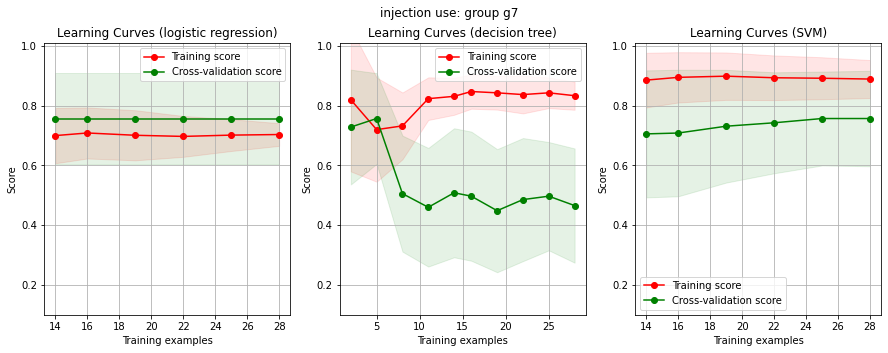

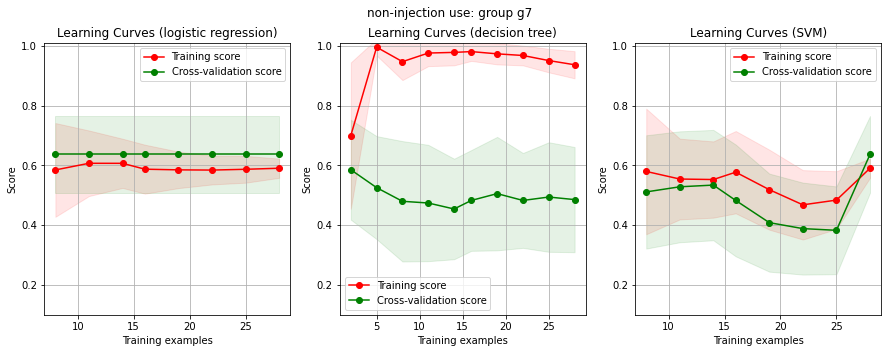

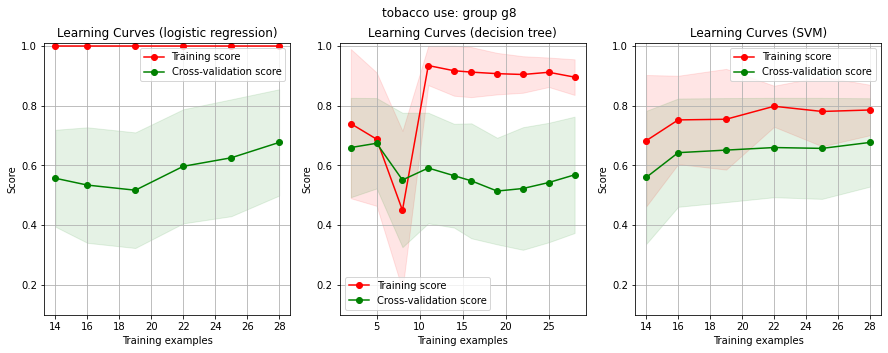

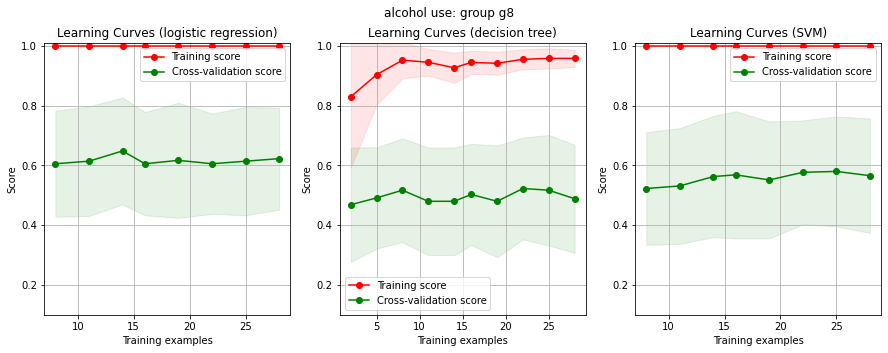

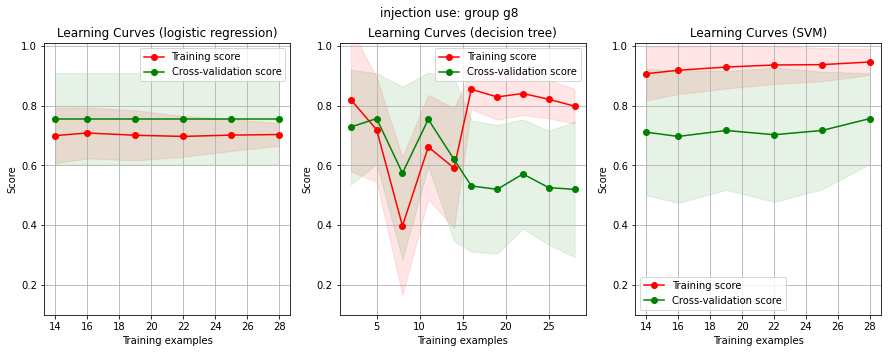

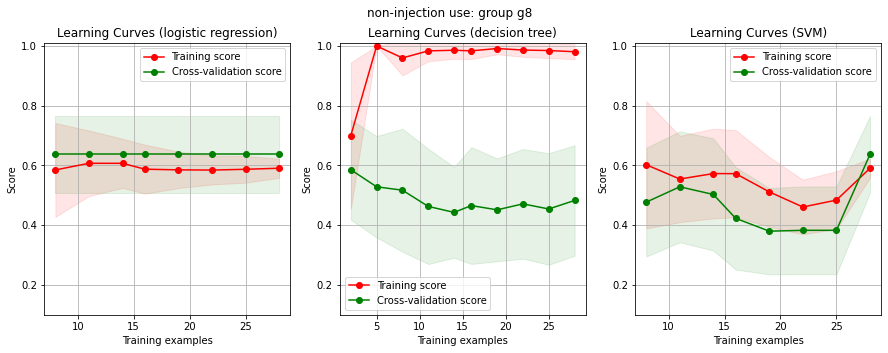

In [113]:
for gname, fsubs in fsubs_all.items():
    X = X_imp[:,get_f_indices(fsubs)]
    for drug, y in y_all.items():  # for each substance
        plot_LC_tuned(X, y, drug, gname)

### Nested vs Non-nested CV

Choosing the hyperparameters that maximize non-nested CV biases the model to the dataset, yielding an overly-optimistic score.

Note that for tuning hyperparameter only, non-nested CV is enough. Nested CV (outer CV in particular) is needed for evaluating the generalization performance.

Average difference of 0.047569 with std. dev. of 0.052767.


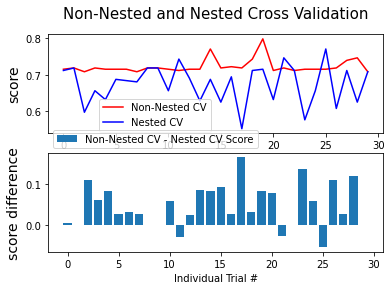

In [29]:
X, y = X_imp[:,get_f_indices(fsubs_8)], y_tobacco

# Number of random trials
NUM_TRIALS = 30

# Set up possible values of parameters to optimize over
p_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])

# We will use a Support Vector Classifier with "rbf" kernel
lg = LogisticRegression(max_iter=1000, random_state=17, class_weight='balanced', solver='liblinear')

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=lg, param_grid=p_grid, cv=outer_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=lg, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()